# Churn prediction for an energy company 🔌💡
## Part 2 - Data Exploration and Feature Engineering
### Importing packages and data

In [1]:
from utils import *

repo_path = "/workspaces/myfolder/energy-churn-prediction"

client_file_path = f"{repo_path}/data/client_data_cleaned.csv"
client_date_cols = ['date_activ', 'date_modif_prod', 'date_renewal', 'date_end']

price_file_path = f"{repo_path}/data/price_data_cleaned.csv"
price_date_col = 'price_date'

# Load the data and convert datetime columns
client_df = load_and_convert_datetime(client_file_path, client_date_cols)
price_df = load_and_convert_datetime(price_file_path, [price_date_col])

### Merging the 2 tables

Let's start with `price_df`, and let's have a look at the distinct values of `price_date` variable and at the number of unique IDs contained in this table:

In [2]:
print(f"Number of unique IDs: {price_df['id'].nunique()}")
print("\n------------------------------------------------\n")
print("Distinct values of the 'price_date' variable:")
price_df[price_date_col].value_counts().sort_index()

Number of unique IDs: 16096

------------------------------------------------

Distinct values of the 'price_date' variable:


price_date
2015-01-01    16070
2015-02-01    16082
2015-03-01    16074
2015-04-01    16079
2015-05-01    16080
2015-06-01    16085
2015-07-01    16090
2015-08-01    16094
2015-09-01    16082
2015-10-01    16085
2015-11-01    16087
2015-12-01    16094
Name: count, dtype: int64

From the information above, we can infer that this table provides information on price values from January to December 2015 for 16096 customers. However, it seems that there are some missing values here and there for some IDs:

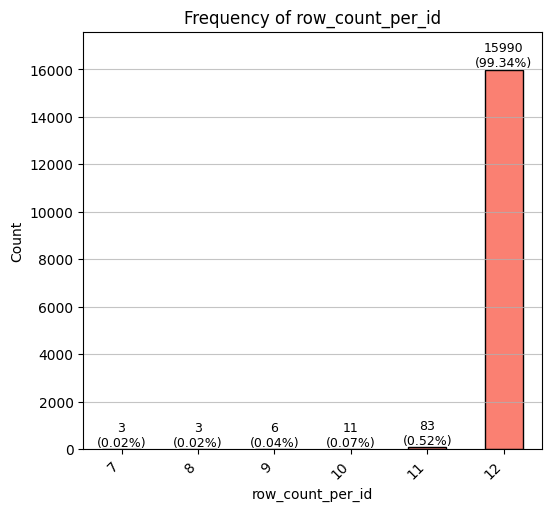

In [3]:
row_counts = price_df.groupby('id').size().reset_index(name='row_count_per_id')

plot_bar_charts(row_counts, ['row_count_per_id'])

We are going to impute these missing values, but let's first check out the correlation matrix between the numeric variables:

`!pip install seaborn --upgrade` in order for the annotation to be correctly seen! Put `requirements.txt` in GitHub repo!

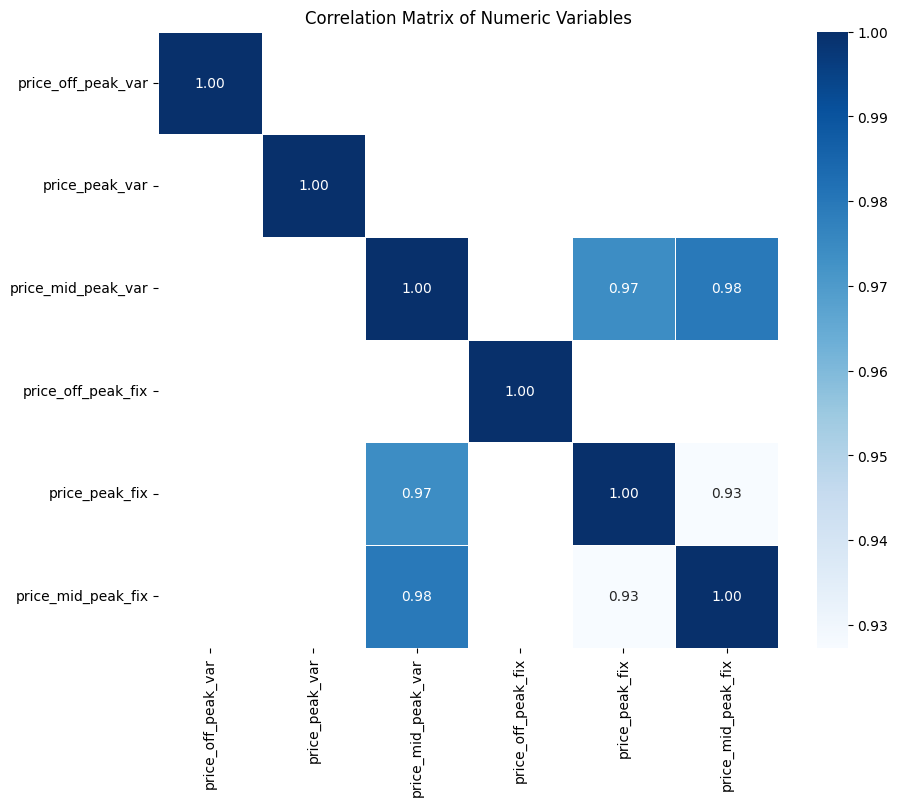

,variable_1,variable_2,correlation
10,price_mid_peak_var,price_peak_fix,0.973960
11,price_mid_peak_var,price_mid_peak_fix,0.979717
14,price_peak_fix,price_mid_peak_fix,0.927308


In [4]:
price_numeric_cols = price_df.select_dtypes(include='number').columns

plot_correlation_matrix(price_df, price_numeric_cols, figsize=(10,8))

As you can see, there are 3 variables very highly correlated among each other: `price_mid_peak_var`, `price_peak_fix`, and `price_mid_peak_fix`. Since this means that they almost carry the same kind of information, I'll consider only one of the 3, i.e. `price_mid_peak_var`, from now on.

In [5]:
price_df.drop(['price_peak_fix', 'price_mid_peak_fix'], axis=1, inplace=True)

Let's now plot the trends for the remaining price variables, by plotting both the average trend and the individual trends for a randomly chosen sample of 50 IDs:

First of all, the number of rows in this case is much higher, and the reason is that for each customer we have more than 1 observation:

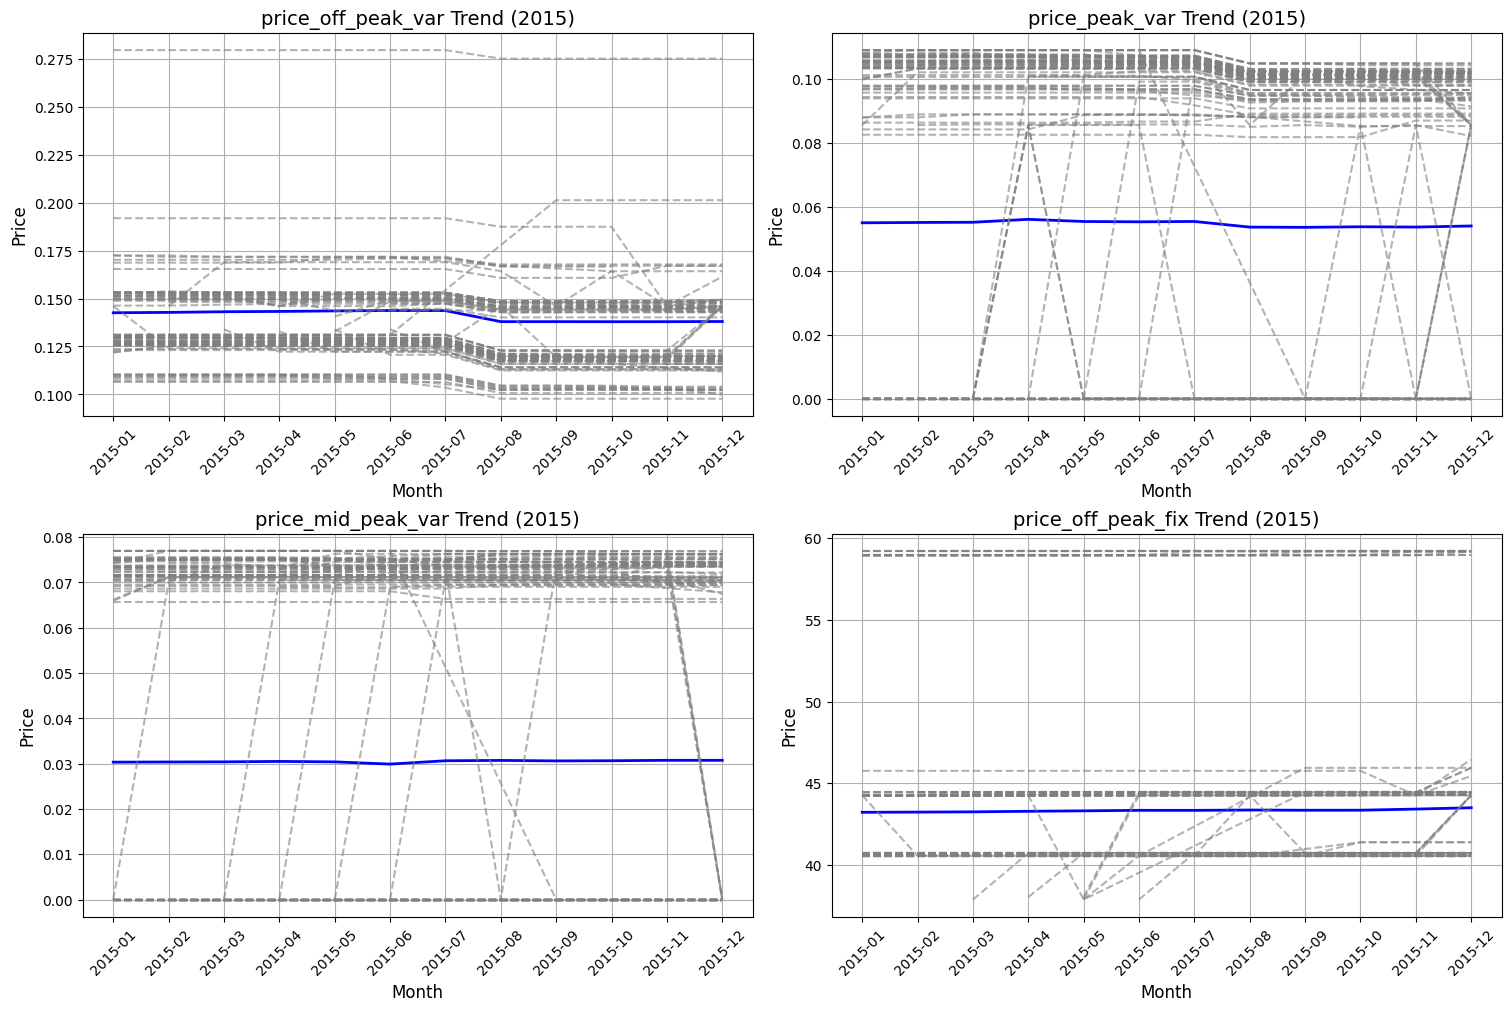

In [6]:
plot_price_trends(price_df, price_numeric_cols, price_date_col, 'id', n_sample=100)

As you can see, while many of the individual trends seem to be represented by an almost constant line, there are some trends containing some spikes or troughs. Therefore, when building price features from these variables, we will also build some features that encapsulate these irregularities in the trends. 

In [7]:
price_cols = [col for col in price_numeric_cols if col in price_df.columns]
price_df = price_df.sort_values(by=['id', price_date_col])

# Group by 'id'
grouped_df = price_df[['id']+price_cols].groupby('id')

# Compute statistics
mean_df = grouped_df.mean()
min_df = grouped_df.min()
max_df = grouped_df.max()
std_df = grouped_df.std()
max_diff_df = grouped_df.agg(lambda x: max(x.iloc[i+1] - x.iloc[i] for i in range(len(x)-1)))

# Rename columns for clarity
mean_df.columns = [f"{col}_mean" for col in price_cols]
min_df.columns = [f"{col}_min" for col in price_cols]
max_df.columns = [f"{col}_max" for col in price_cols]
std_df.columns = [f"{col}_std" for col in price_cols]
max_diff_df.columns = [f"{col}_max_diff" for col in price_cols]

# Join all DataFrames on 'id'
price_summary_df = pd.concat([mean_df, min_df, max_df, std_df, max_diff_df], axis=1)

# Reset index for a cleaner DataFrame if needed
price_summary_df.reset_index(inplace=True)

price_summary_df

,id,price_off_peak_var_mean,price_peak_var_mean,price_mid_peak_var_mean,price_off_peak_fix_mean,price_off_peak_var_min,price_peak_var_min,price_mid_peak_var_min,price_off_peak_fix_min,price_off_peak_var_max,...,price_mid_peak_var_max,price_off_peak_fix_max,price_off_peak_var_std,price_peak_var_std,price_mid_peak_var_std,price_off_peak_fix_std,price_off_peak_var_max_diff,price_peak_var_max_diff,price_mid_peak_var_max_diff,price_off_peak_fix_max_diff
0,0002203ffbb812588b632b9e628cc38d,0.124338,0.103794,0.073160,40.701732,0.119906,0.101673,0.070232,40.565969,0.128067,...,0.073773,40.728885,0.003976,0.001989,0.001368,6.341481e-02,0.001969,0.001867,0.003541,0.162916
1,0004351ebdd665e6ee664792efc4fd13,0.146426,0.000000,0.000000,44.385450,0.143943,0.000000,0.000000,44.266931,0.148405,...,0.000000,44.444710,0.002197,0.000000,0.000000,8.753223e-02,0.000358,0.000000,0.000000,0.177779
2,0010bcc39e42b3c2131ed2ce55246e3c,0.181558,0.000000,0.000000,45.319710,0.150837,0.000000,0.000000,44.444710,0.205742,...,0.000000,45.944710,0.026008,0.000000,0.000000,7.723930e-01,0.052694,0.000000,0.000000,1.500000
3,0010ee3855fdea87602a5b7aba8e42de,0.118757,0.098292,0.069032,40.647427,0.113068,0.095385,0.068646,40.565969,0.123086,...,0.069463,40.728885,0.005049,0.002580,0.000403,8.507958e-02,0.000000,0.000000,0.000817,0.162912
4,00114d74e963e47177db89bc70108537,0.147926,0.000000,0.000000,44.266930,0.145440,0.000000,0.000000,44.266930,0.149902,...,0.000000,44.266931,0.002202,0.000000,0.000000,5.908392e-07,0.000468,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16091,ffef185810e44254c3a4c6395e6b4d8a,0.138863,0.115125,0.080780,40.896427,0.112488,0.094804,0.068829,40.728885,0.165037,...,0.093881,41.063970,0.026238,0.020548,0.012503,1.749923e-01,0.002317,0.002317,0.002317,0.000000
16092,fffac626da707b1b5ab11e8431a4d0a2,0.147137,0.000000,0.000000,44.311375,0.144363,0.000000,0.000000,44.266930,0.148825,...,0.000000,44.444710,0.002098,0.000000,0.000000,8.040373e-02,0.000684,0.000000,0.000000,0.177780
16093,fffc0cacd305dd51f316424bbb08d1bd,0.153879,0.129497,0.094842,41.160171,0.151399,0.126871,0.091394,41.063970,0.159560,...,0.101037,41.228885,0.003044,0.002447,0.004310,8.491973e-02,0.004084,0.002317,0.002317,0.164916
16094,fffe4f5646aa39c7f97f95ae2679ce64,0.123858,0.103499,0.073735,40.606699,0.118175,0.100491,0.073433,40.565969,0.127566,...,0.074516,40.728885,0.004600,0.002397,0.000471,7.368063e-02,0.000000,0.000000,0.001083,0.162912


Before analyzing the distribution of these numeric variables, let's perform an inner join `price_summary_df` with `client_df`:

In [8]:
# Perform an inner join based on 'id'
merged_df = pd.merge(client_df, price_summary_df, on='id', how='inner')

merged_df

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,price_mid_peak_var_max,price_off_peak_fix_max,price_off_peak_var_std,price_peak_var_std,price_mid_peak_var_std,price_off_peak_fix_std,price_off_peak_var_max_diff,price_peak_var_max_diff,price_mid_peak_var_max_diff,price_off_peak_fix_max_diff
0,24011ae4ebbe3035111d65fa7c15bc57,Channel 1,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,0.073873,44.266930,0.007829,0.005126,0.020983,1.050136e+00,0.028554,0.000568,0.002337,3.538045
1,d29c2c54acc38ff3c0614d0a653813dd,Channel Missing,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,0.000000,44.444710,0.002212,0.024677,0.000000,8.040385e-02,0.001567,0.085483,0.000000,0.177780
2,764c75f661154dac3a6c254cd082ea7d,Channel 1,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,0.000000,44.444710,0.002396,0.000506,0.000000,8.753223e-02,0.000000,0.001281,0.000000,0.177779
3,bba03439a292a1e166f80264c16191cb,Channel 2,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,...,0.000000,44.444710,0.002317,0.000000,0.000000,8.040349e-02,0.000000,0.000000,0.000000,0.177779
4,149d57cf92fc41cf94415803a877cb4b,Channel Missing,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,...,0.073773,40.728885,0.003847,0.001885,0.001588,7.368135e-02,0.001969,0.001867,0.003541,0.162916
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14524,18463073fb097fc0ac5d3e040f356987,Channel 1,32270,47940,0,2012-05-24,2016-05-08,2015-05-08,2014-05-26,4648.01,...,0.000000,44.444710,0.003897,0.000000,0.000000,9.154352e-02,0.000569,0.000000,0.000000,0.177780
14525,d0a6f71671571ed83b2645d23af6de00,Channel 1,7223,0,181,2012-08-27,2016-08-27,2012-08-27,2015-08-28,631.69,...,0.070990,59.173468,0.003669,0.001863,0.000128,1.165389e-01,0.000000,0.000000,0.000260,0.236688
14526,10e6828ddd62cbcf687cb74928c4c2d2,Channel 1,1844,0,179,2012-02-08,2016-02-07,2012-02-08,2015-02-09,190.39,...,0.073773,40.728885,0.003976,0.001989,0.001368,6.341481e-02,0.001969,0.001867,0.003541,0.162916
14527,1cf20fd6206d7678d5bcafd28c53b4db,Channel 1,131,0,0,2012-08-30,2016-08-30,2012-08-30,2015-08-31,19.34,...,0.000000,44.444710,0.002212,0.024677,0.000000,8.040379e-02,0.001567,0.085483,0.000000,0.177780


#### Analysis of Numeric variables

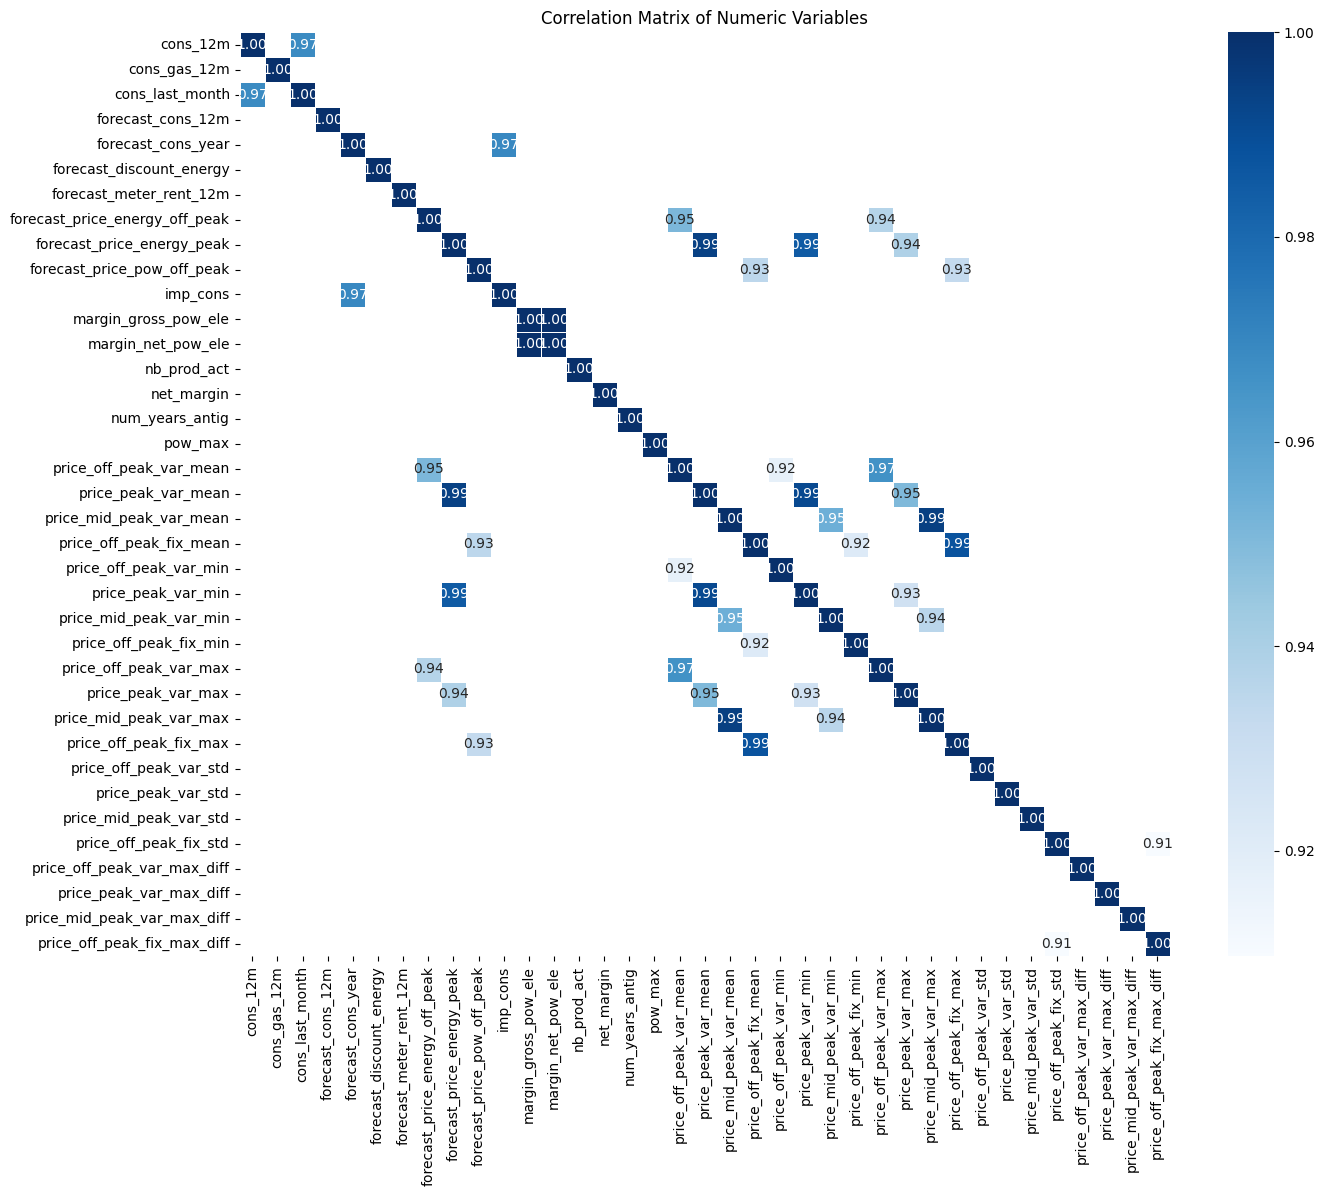

In [9]:
high_corr_pairs = plot_correlation_matrix(merged_df, merged_df.select_dtypes(include='number').columns)

In [10]:
high_corr_pairs.sort_values(by="correlation", ascending=False)

,variable_1,variable_2,correlation
341,margin_gross_pow_ele,margin_net_pow_ele,0.999913
520,price_mid_peak_var_mean,price_mid_peak_var_max,0.994531
269,forecast_price_energy_peak,price_peak_var_mean,0.994020
498,price_peak_var_mean,price_peak_var_min,0.991290
537,price_off_peak_fix_mean,price_off_peak_fix_max,0.987696
273,forecast_price_energy_peak,price_peak_var_min,0.985054
143,forecast_cons_year,imp_cons,0.969381
1,cons_12m,cons_last_month,0.968508
483,price_off_peak_var_mean,price_off_peak_var_max,0.966131
516,price_mid_peak_var_mean,price_mid_peak_var_min,0.954349


For the same reasoning as before, we decide to keep only one variable for each pair of highly correlated variables, i.e. the distinct variables in `variable_2` column:

In [11]:
merged_df.drop(high_corr_pairs['variable_1'].unique(), axis=1, inplace=True)

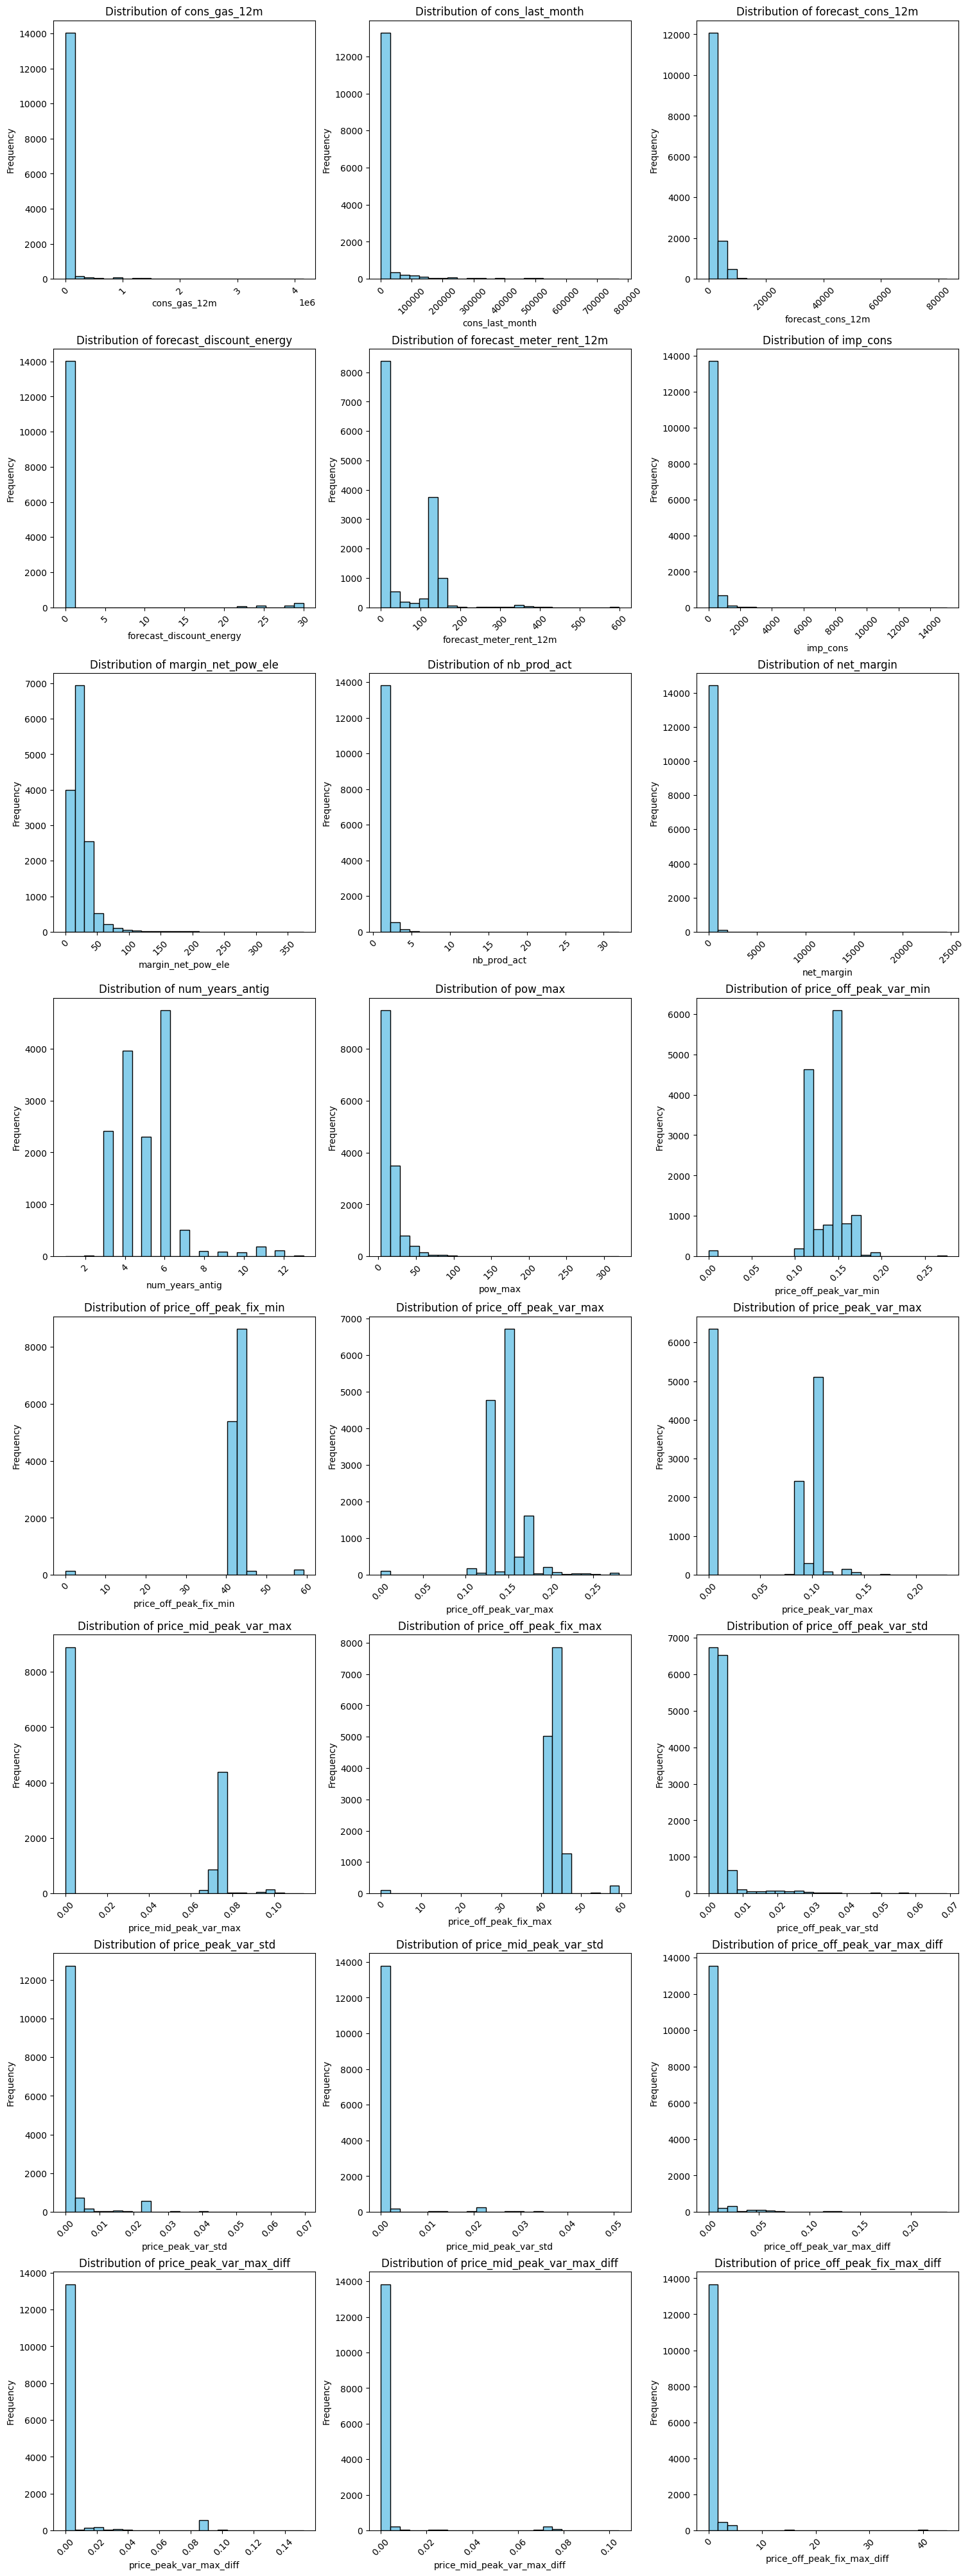

In [12]:
numeric_cols = merged_df.select_dtypes(include='number').columns

plot_numeric_distributions(merged_df, numeric_cols)

As we can see, there are many extremely skewed predictors. This can be problematic because the number of observations available to predict the target varies greatly across the range of the input values. To have a better understanding of the problem, let's first compute skewness, number of 0s, and cardinality for each of the numeric columns: 

In [13]:
num_stats_df = compute_and_sort_statistics(merged_df, numeric_cols, by='cardinality', ascending=True)
num_stats_df

,skewness,zero_counts,cardinality
nb_prod_act,8.665068,0,10
forecast_discount_energy,5.145705,14018,12
num_years_antig,1.448207,0,13
price_off_peak_fix_min,-5.739459,139,30
price_off_peak_fix_max,-5.252087,105,39
price_off_peak_fix_max_diff,15.524186,3172,111
price_mid_peak_var_max,0.487314,8896,206
price_peak_var_max,-0.161301,6357,313
price_off_peak_var_max,-0.458833,20,498
price_off_peak_var_min,-1.682037,65,675


There are 5 variables with less than 50 unique values: `forecast_discount_energy`, `nb_prod_act` and `num_years_antig`, `price_off_peak_fix_min`, and `price_off_peak_fix_max`. Let's plot their value frequencies:

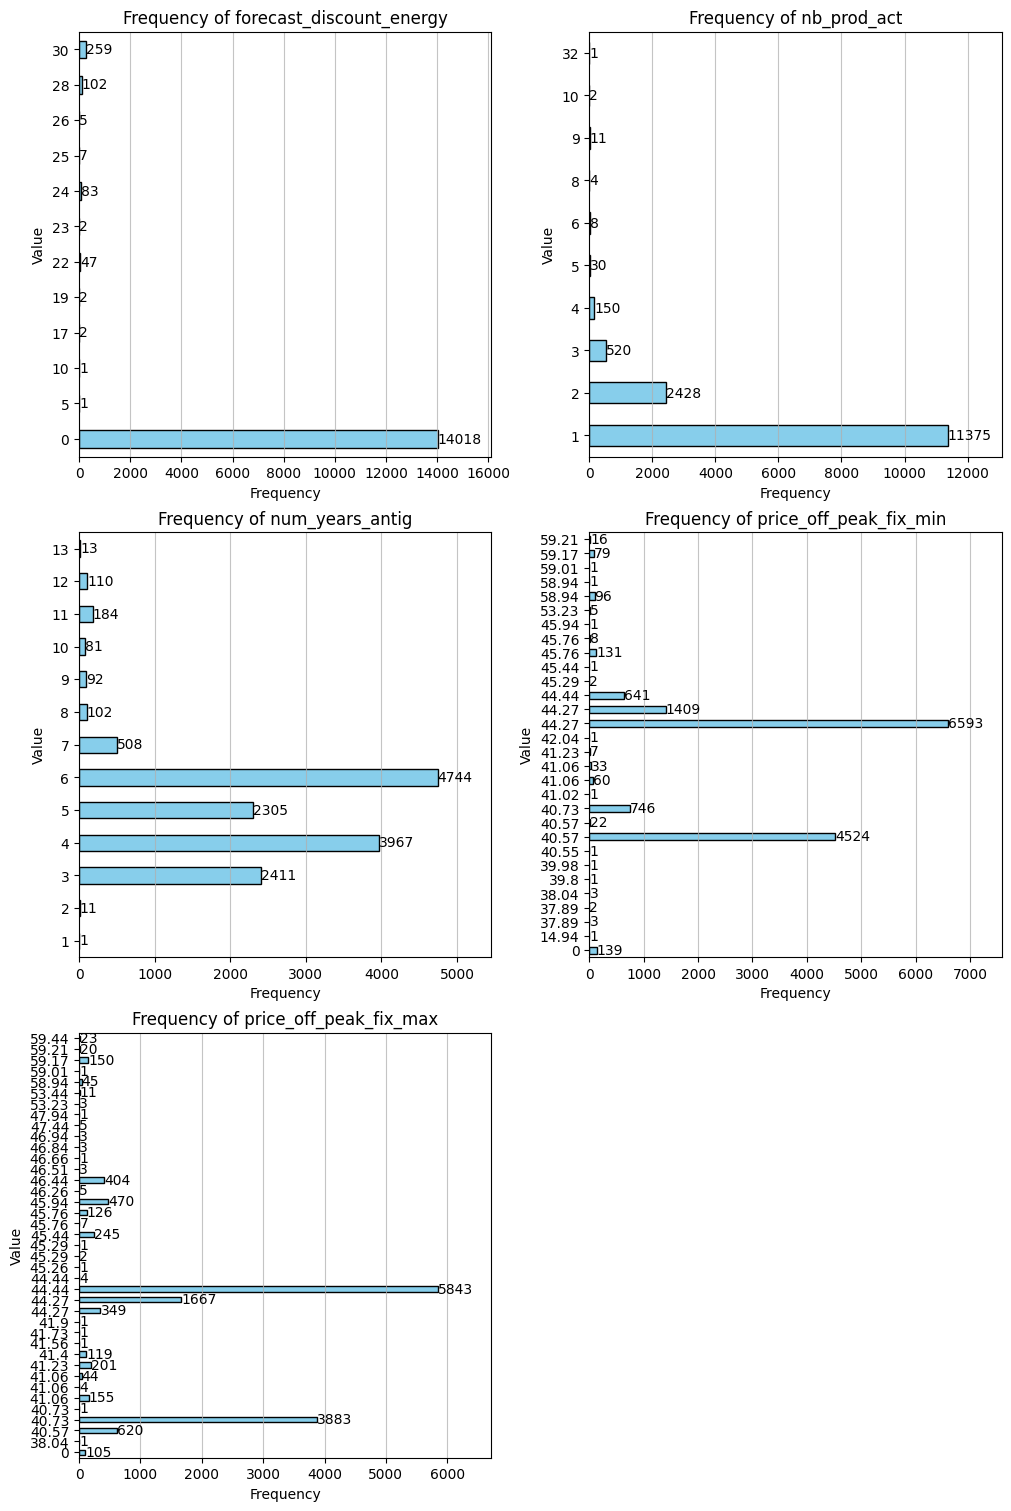

In [14]:
low_cardinality_cols = [col for col in numeric_cols if num_stats_df.loc[col, 'cardinality']<50]

plot_bar_charts(merged_df, low_cardinality_cols, orientation='horizontal')

For these 4 variables, I decided to create the following categorical variables to see if they might be helpful in reducing overfit and generalize better on unseen data:
- `nb_prod_act`: 3 categories: '1', '2' and '3 or more'
- `num_years_antig`: 5 categories: '3 or less', '4', '5', '6' and '7 or more'
- `forecast_discount_energy`: in this case, since less than 4% of the data has a value different than 0, I decided to just create a flag with values '0' and '>0'
- `price_off_peak_fix_min` and `price_off_peak_fix_max`: for these variables, a sensible choice seems to be a split in 3 categories: '0', '>0 and <=42', '>42'

In [15]:
# Transformation for `nb_prod_act`
merged_df['nb_prod_act_cat'] = np.where(merged_df['nb_prod_act'] >= 3, '3 or more',
                                        merged_df['nb_prod_act'].astype(str))

# Transformation for `num_years_antig`
merged_df['num_years_antig_cat'] = np.where(merged_df['num_years_antig'] <= 3, '3 or less',
                                        np.where(merged_df['num_years_antig'] == 4, '4',
                                                np.where(merged_df['num_years_antig'] == 5, '5',
                                                        np.where(merged_df['num_years_antig'] == 6, '6', '7 or more'))))

# Transformation for `forecast_discount_energy`
merged_df['forecast_discount_energy_cat'] = np.where(merged_df['forecast_discount_energy'] > 0, '>0', '0')

# Transformation for `forecast_price_pow_off_peak`, `price_off_peak_fix_min` and `price_off_peak_fix_max`
for col in ['price_off_peak_fix_min', 'price_off_peak_fix_max']:
#for col in ['price_off_peak_fix_min', 'price_off_peak_fix_max', 'forecast_price_pow_off_peak']:
    merged_df[f'{col}_cat'] = np.where(merged_df[col] == 0, '0',
                                        np.where(merged_df[col] <= 42, '>0 and <=42', '>42'))

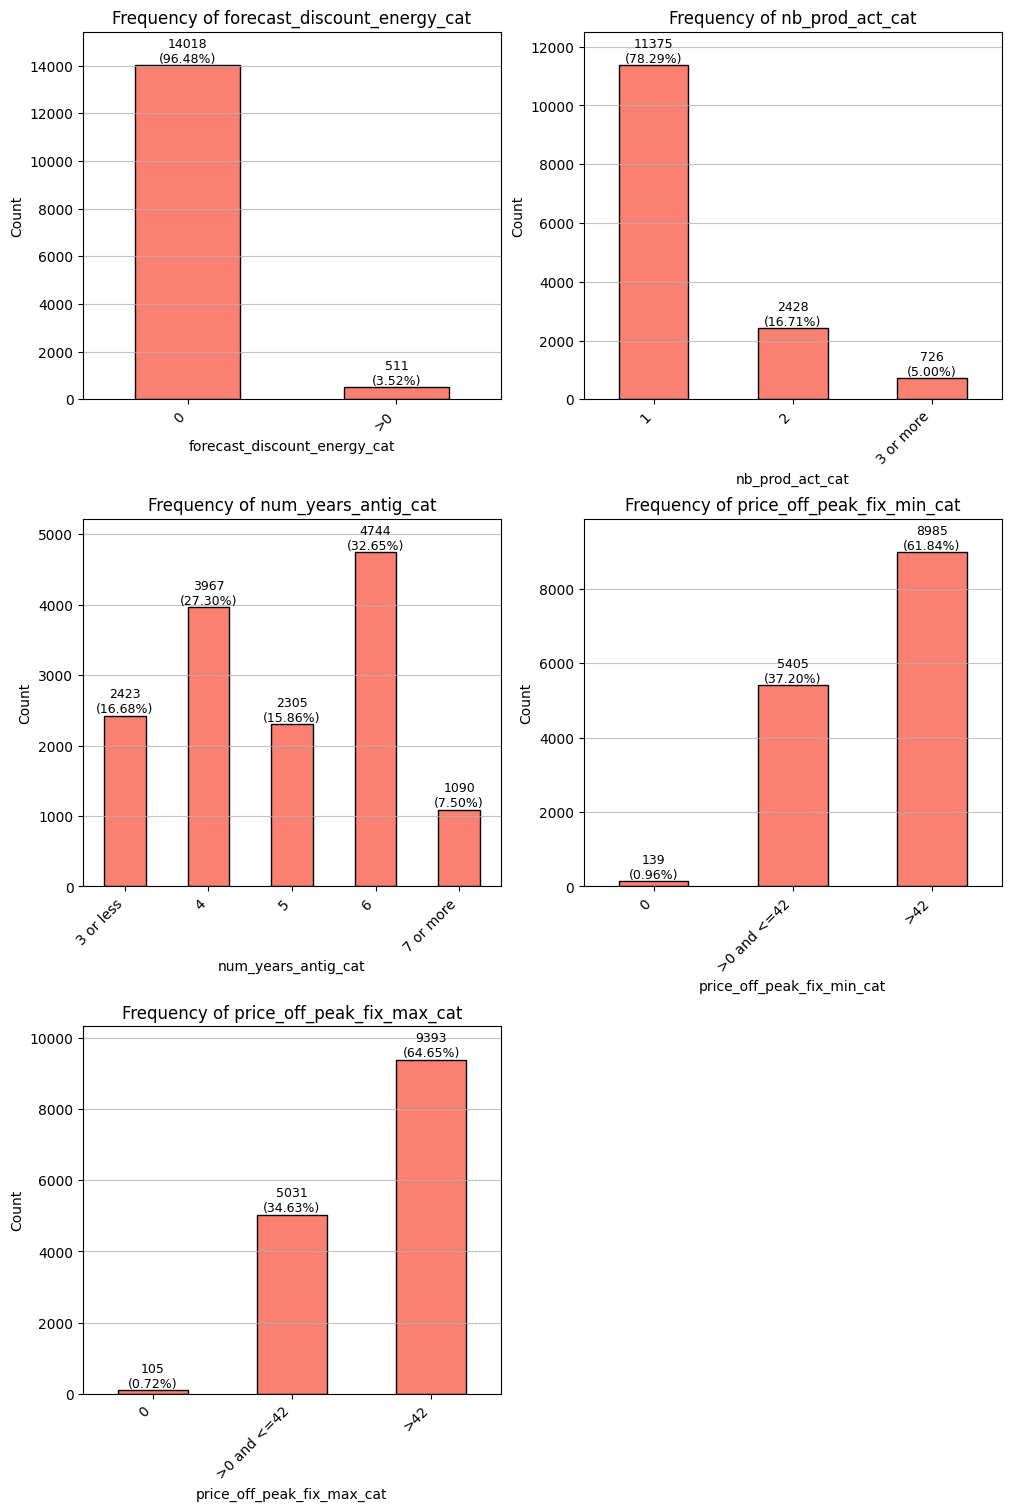

In [16]:
categorized_cols = [f'{col}_cat' for col in low_cardinality_cols]

plot_bar_charts(merged_df, categorized_cols, orientation='vertical')

In [17]:
merged_df.drop(low_cardinality_cols, axis=1, inplace=True)

Let's now focus on the remaining numeric variables:

In [18]:
num_stats_df = num_stats_df[num_stats_df['cardinality']>=50].sort_values(by='zero_counts', ascending=False)
num_stats_df

,skewness,zero_counts,cardinality
cons_gas_12m,9.640002,11975,2059
price_mid_peak_var_max_diff,5.882666,9603,680
price_mid_peak_var_std,5.664527,8968,1894
price_mid_peak_var_max,0.487314,8896,206
price_peak_var_max_diff,4.143847,8229,939
price_peak_var_std,4.314246,6357,2687
price_peak_var_max,-0.161301,6357,313
imp_cons,13.183958,6124,7728
price_off_peak_var_max_diff,6.794844,5340,1364
cons_last_month,6.374610,4946,4740


There are several columns with many rows having value 0. Let's see the distributions of the variables with more than 30% of 0 values when removing all these 0 rows:

Skewness for column cons_gas_12m (excluding zeros): 3.912
---------------------------------
Skewness for column price_mid_peak_var_max_diff (excluding zeros): 3.199
---------------------------------
Skewness for column price_mid_peak_var_std (excluding zeros): 3.348
---------------------------------
Skewness for column price_mid_peak_var_max (excluding zeros): 2.997
---------------------------------
Skewness for column price_peak_var_max_diff (excluding zeros): 2.448
---------------------------------
Skewness for column price_peak_var_std (excluding zeros): 3.239
---------------------------------
Skewness for column price_peak_var_max (excluding zeros): 1.115
---------------------------------
Skewness for column imp_cons (excluding zeros): 11.923
---------------------------------
Skewness for column price_off_peak_var_max_diff (excluding zeros): 5.405
---------------------------------
Skewness for column cons_last_month (excluding zeros): 5.122
---------------------------------


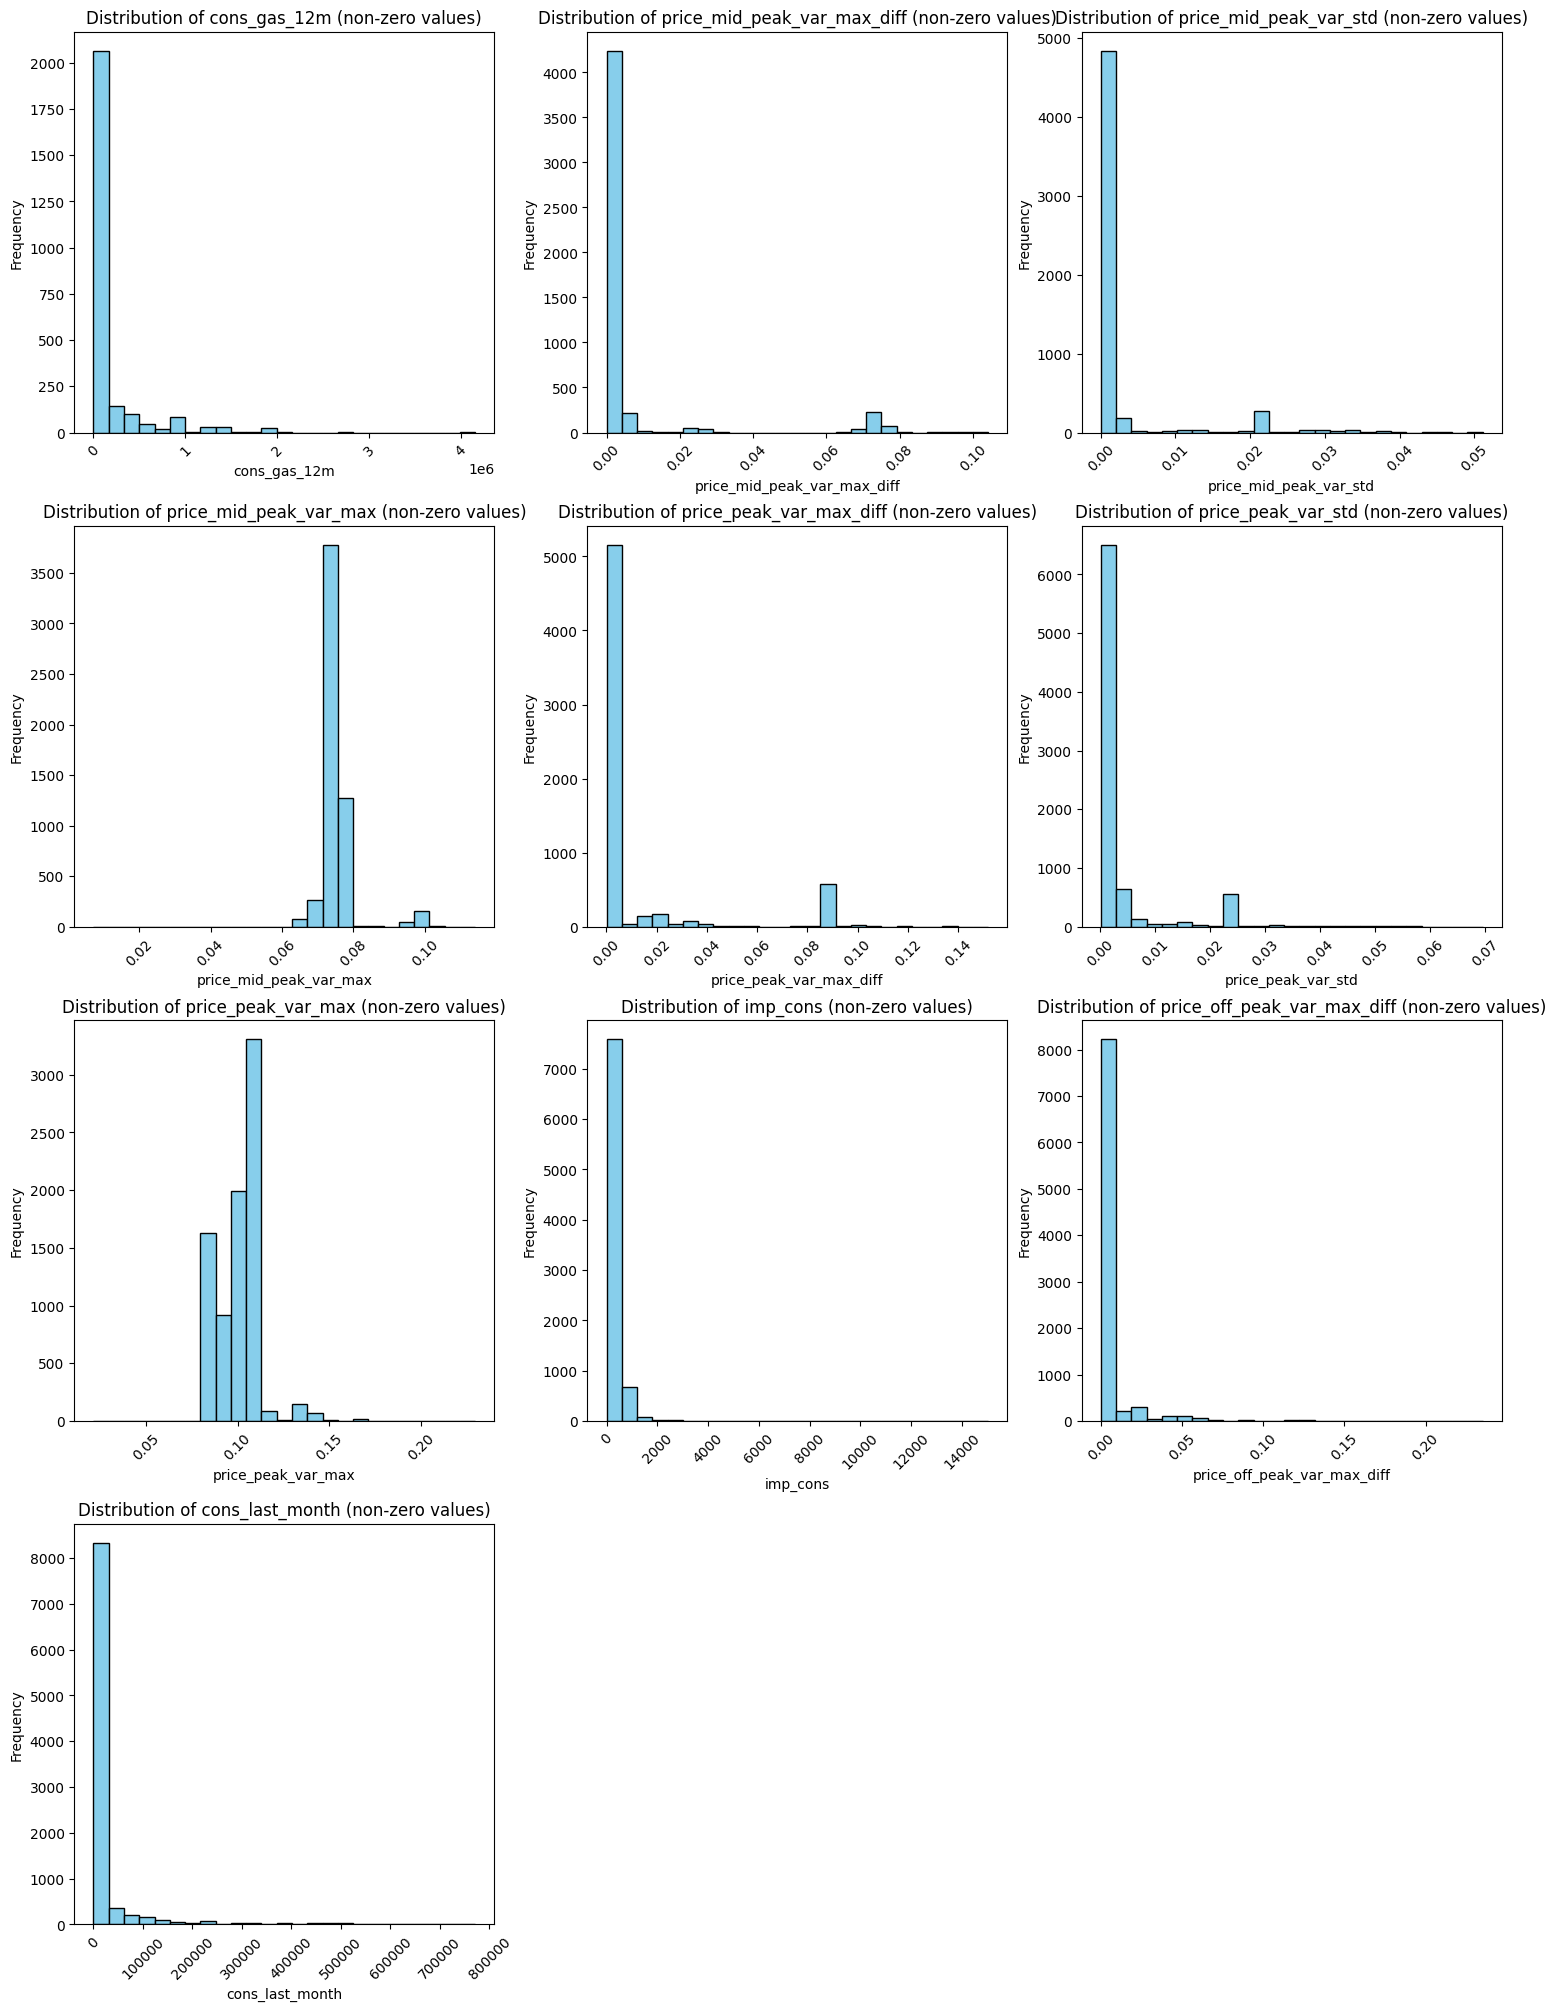

In [19]:
cols_with_high_cardinality = [col for col in num_stats_df.index]

plot_histograms_for_sparse_cols(merged_df, cols_with_high_cardinality, zero_threshold=0.3)

Some of these distributions remain highly skewed even when removing the 0 values. For all these variables, we can consider to build:
- a flag indicator telling whether the variable is in the spike (0 value) or in the distribution (non-zero value).
- perform a log transformation on the values of the distribution (except for the variables whose skewness is less than 3 when removing the 0 rows), and afterwards replacing zero values with the value minimizing the impact on the relationship between the predictor and the response, estimated by the **Point-Biserial correlation coefficient**.

In [20]:
many_zeros_cols = [col for col in num_stats_df.index if num_stats_df.loc[col,'zero_counts']>0.3*len(merged_df)]

merged_df, skewness, distr_transformed_cols = apply_log_transformation_and_impute(merged_df, many_zeros_cols, skewness_threshold=3.0, target='churn')

Original Point-Biserial Correlation for cons_gas_12m_log: -0.057
Best imputation for cons_gas_12m: 7.509531881553
Point-Biserial Correlation difference: 0.024215454274086036
Original Point-Biserial Correlation for price_mid_peak_var_max_diff_log: 0.013
Best imputation for price_mid_peak_var_max_diff: 0.005008106166395952
Point-Biserial Correlation difference: 0.0009644441797467557
Original Point-Biserial Correlation for price_mid_peak_var_std_log: 0.009
Best imputation for price_mid_peak_var_std: 0.0025380143549958013
Point-Biserial Correlation difference: 4.588067290299883e-06
Original Point-Biserial Correlation for price_mid_peak_var_max_distr: 0.034
Best imputation for price_mid_peak_var_max: 0.07307505050505046
Point-Biserial Correlation difference: 0.0024202660785561728
Original Point-Biserial Correlation for price_peak_var_max_diff_distr: 0.006
Best imputation for price_peak_var_max_diff: 0.0077268080808079835
Point-Biserial Correlation difference: 0.00021395457938928279
Original

Skewness for column cons_gas_12m_log: 2.742
---------------------------------
Skewness for column price_mid_peak_var_max_diff_log: 5.869
---------------------------------
Skewness for column price_mid_peak_var_std_log: 5.588
---------------------------------
Skewness for column price_mid_peak_var_max_distr: 5.199
---------------------------------
Skewness for column price_peak_var_max_diff_distr: 4.053
---------------------------------
Skewness for column price_peak_var_std_log: 4.447
---------------------------------
Skewness for column price_peak_var_max_distr: 1.910
---------------------------------
Skewness for column imp_cons_log: -1.584
---------------------------------
Skewness for column price_off_peak_var_max_diff_log: 6.554
---------------------------------
Skewness for column cons_last_month_log: 0.084
---------------------------------


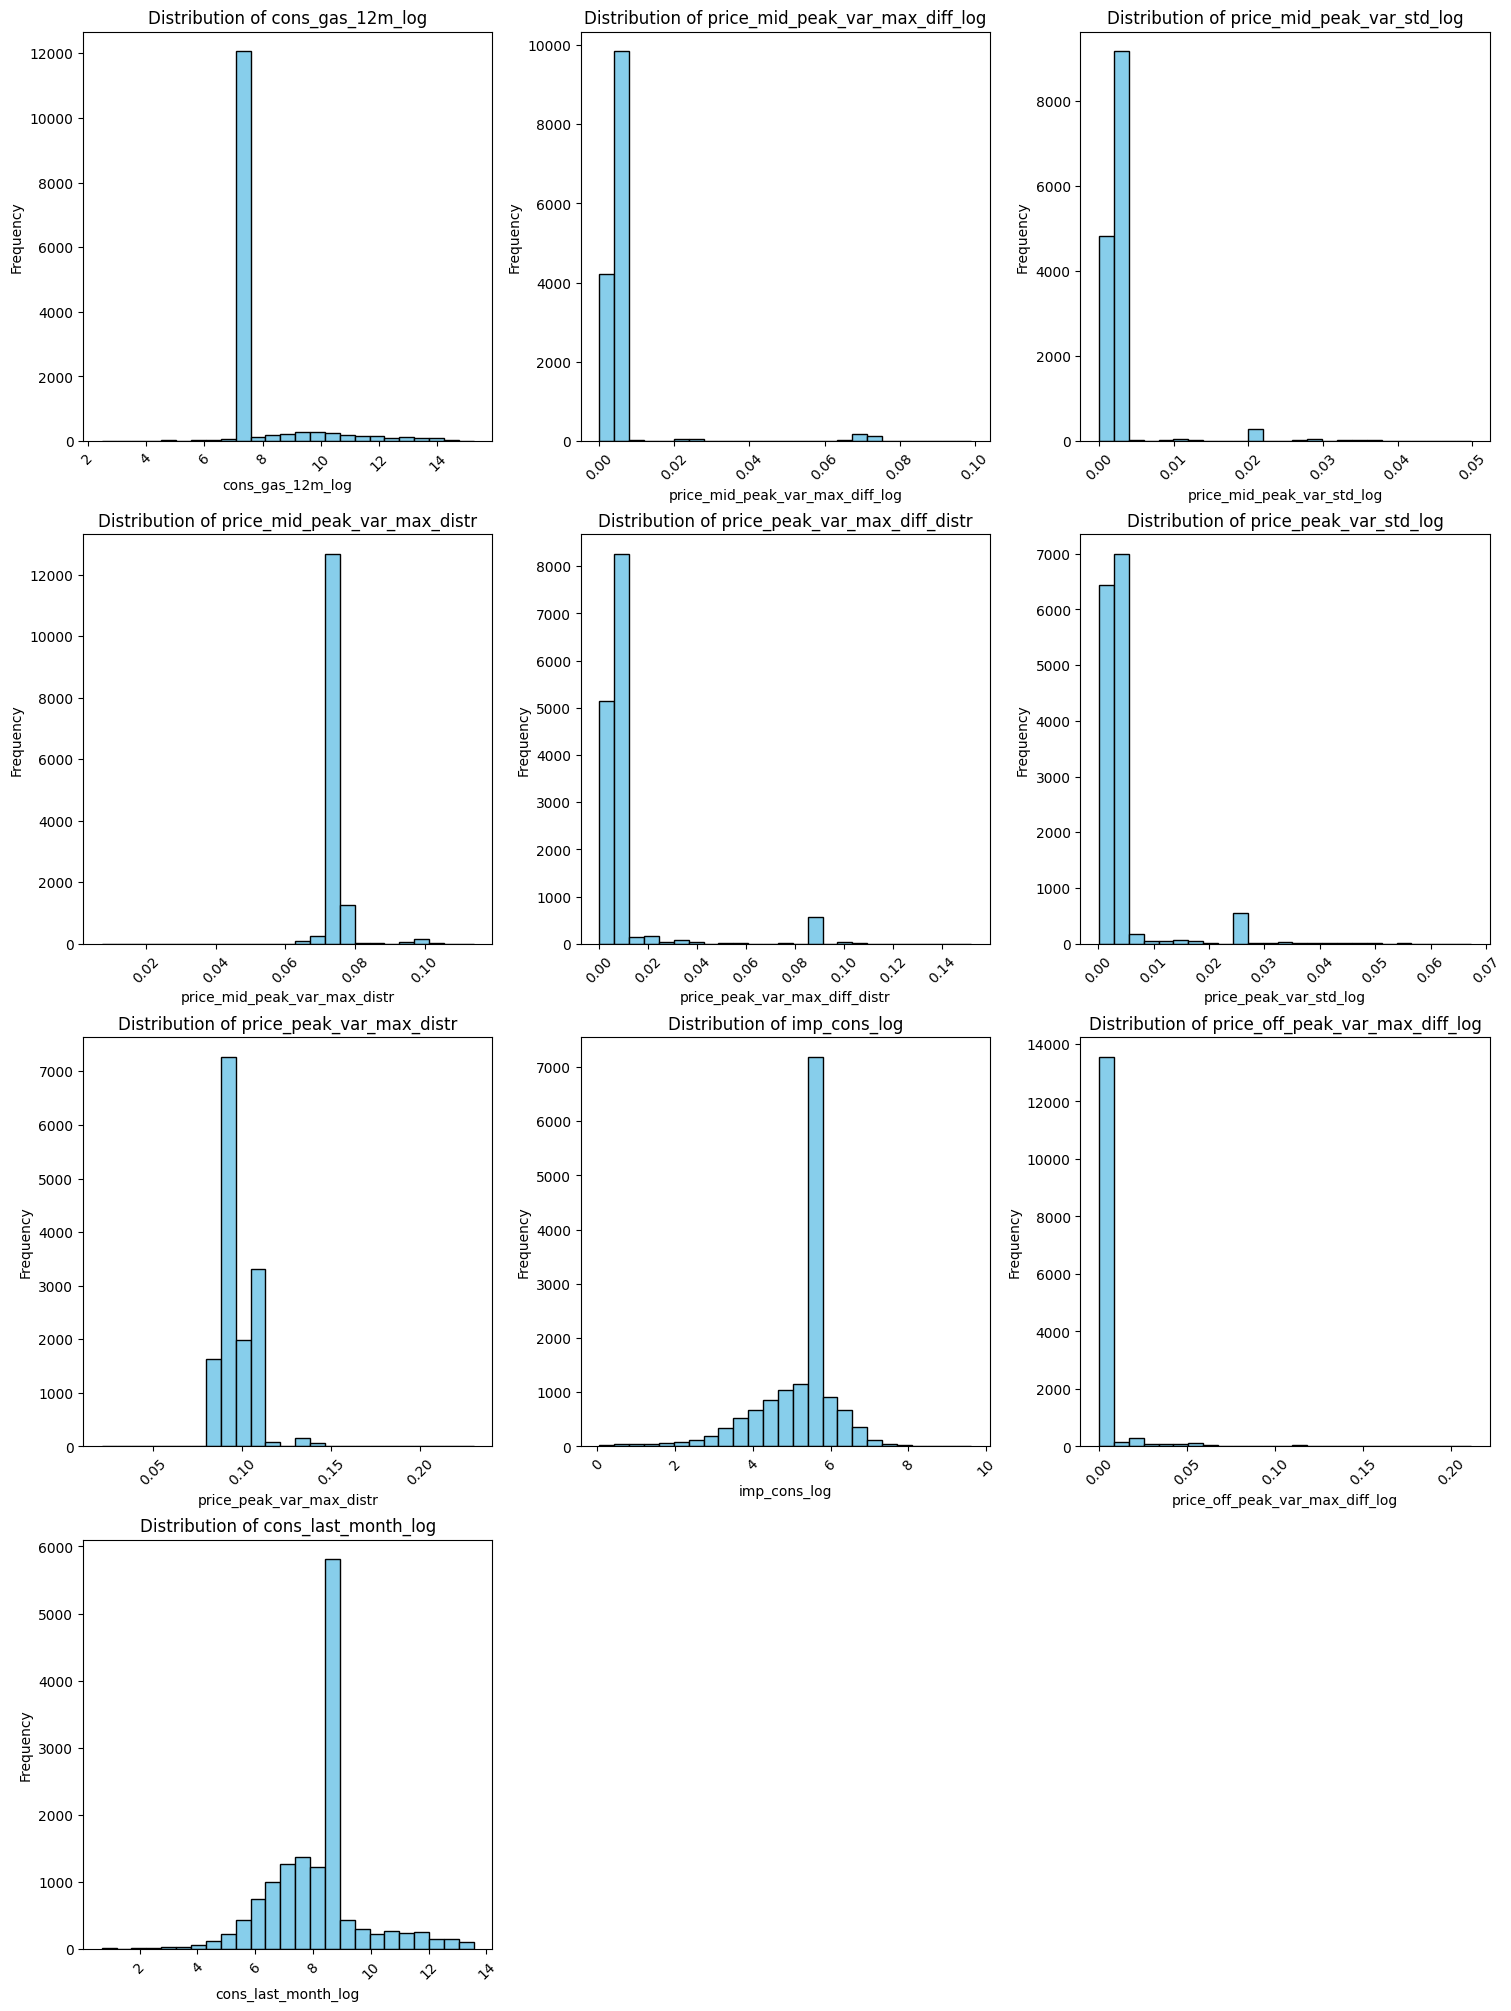

In [21]:
for i, col in enumerate(distr_transformed_cols):
    col_skewness = merged_df[col].skew()
    print(f'Skewness for column {col}: {col_skewness:.3f}')
    print('---------------------------------')

plot_numeric_distributions(merged_df, distr_transformed_cols)

In [22]:
merged_df.drop(many_zeros_cols, axis=1, inplace=True)

In [23]:
num_stats_df = num_stats_df[num_stats_df['zero_counts']<=0.3*len(merged_df)].sort_values(by='skewness', ascending=False)
num_stats_df

,skewness,zero_counts,cardinality
net_margin,36.540197,184,11917
price_off_peak_fix_max_diff,15.524186,3172,111
forecast_cons_12m,7.153735,305,13922
price_off_peak_var_std,6.455391,100,4655
pow_max,5.787936,0,693
margin_net_pow_ele,4.475705,157,2381
forecast_meter_rent_12m,1.507597,722,3512
price_off_peak_var_max,-0.458833,20,498
price_off_peak_var_min,-1.682037,65,675


Finally, I decided to perform a log transformation on all of the remaining variables whose skewness is greater than 3:

In [24]:
# Identify columns with skewness greater than 3
cols_to_transform = [col for col in num_stats_df.index if num_stats_df.loc[col,'skewness']>3]
transformed_cols = [f"{col}_log" for col in cols_to_transform]

# Apply log transformation to these columns
merged_df[transformed_cols] = merged_df[cols_to_transform].apply(lambda x: np.log1p(x))

# Print the transformed columns
print(f"Transformed columns: {cols_to_transform}")

Transformed columns: ['net_margin', 'price_off_peak_fix_max_diff', 'forecast_cons_12m', 'price_off_peak_var_std', 'pow_max', 'margin_net_pow_ele']


Skewness for column net_margin_log: -0.968
---------------------------------
Skewness for column price_off_peak_fix_max_diff_log: 3.742
---------------------------------
Skewness for column forecast_cons_12m_log: -2.034
---------------------------------
Skewness for column price_off_peak_var_std_log: 6.363
---------------------------------
Skewness for column pow_max_log: 1.805
---------------------------------
Skewness for column margin_net_pow_ele_log: -1.310
---------------------------------


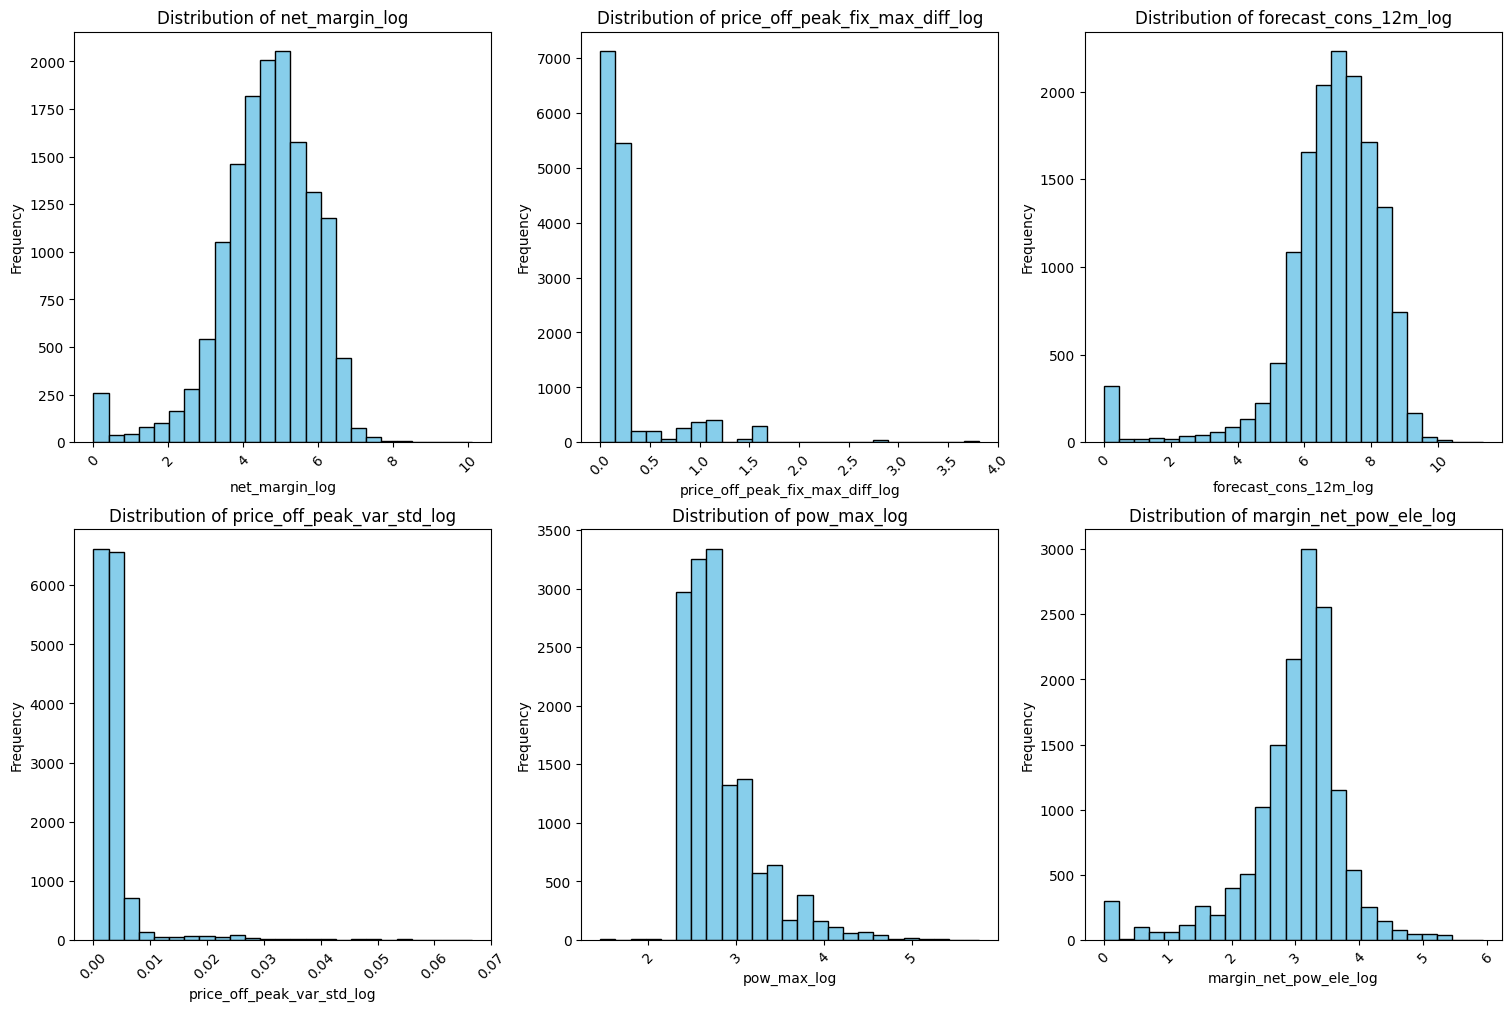

In [25]:
for i, col in enumerate(transformed_cols):
    col_skewness = merged_df[col].skew()
    print(f'Skewness for column {col}: {col_skewness:.3f}')
    print('---------------------------------')

plot_numeric_distributions(merged_df, transformed_cols)

In [26]:
merged_df.drop(cols_to_transform, axis=1, inplace=True)

Let's now move to the date variables.

#### Date variables

In [27]:
# 2. Create a table with min and max values for each date variable
datetime_cols = merged_df.select_dtypes(include=['datetime']).columns
date_summary = merged_df[datetime_cols].agg(['min', 'max']).transpose()
date_summary.columns = ['Minimum Date', 'Maximum Date']

# Display the results
print("Date Summary Table:")
date_summary

Date Summary Table:


,Minimum Date,Maximum Date
date_activ,2003-05-09,2014-09-01
date_end,2016-01-28,2017-06-13
date_modif_prod,2003-05-09,2016-01-29
date_renewal,2013-06-26,2016-01-28


Before removing the date variables from the dataset, let's create some features out of them:
- `product_modified`: this variable can take value 0 or 1, depending on whether `date_modif_prod` is equal to 0 or greater than 1, respectively
- `days_to_end`: this variable computes the number of days between the end of the historical period (December 31, 2015) and the registered date of the end of the contract

In [28]:
# Compute 'product_modified'
merged_df.loc[:, 'product_modified'] = (merged_df['date_modif_prod'] > merged_df['date_activ']).astype(int)

# Compute 'days_to_end'
historical_end_date = pd.Timestamp('2015-12-31')
merged_df.loc[:, 'days_to_end'] = (merged_df['date_end'] - historical_end_date).dt.days

merged_df[['date_activ', 'date_modif_prod', 'product_modified', 'date_end', 'days_to_end']].head(10)

,date_activ,date_modif_prod,product_modified,date_end,days_to_end
0,2013-06-15,2015-11-01,1,2016-06-15,167
1,2009-08-21,2009-08-21,0,2016-08-30,243
2,2010-04-16,2010-04-16,0,2016-04-16,107
3,2010-03-30,2010-03-30,0,2016-03-30,90
4,2010-01-13,2010-01-13,0,2016-03-07,67
5,2011-12-09,2015-11-01,1,2016-12-09,344
6,2011-12-02,2011-12-02,0,2016-12-02,337
7,2010-04-21,2010-04-21,0,2016-04-21,112
8,2011-09-23,2011-09-23,0,2016-09-23,267
9,2010-05-04,2015-04-29,1,2016-05-04,125


In [29]:
merged_df.drop(datetime_cols, axis=1, inplace=True)

#### Categorical variables

In [30]:
categorical_cols = [col for col in merged_df.select_dtypes(exclude='number').columns if (col!='id') and (col not in categorized_cols)]
categorical_cols

['channel_sales', 'has_gas', 'origin_up', 'churn']

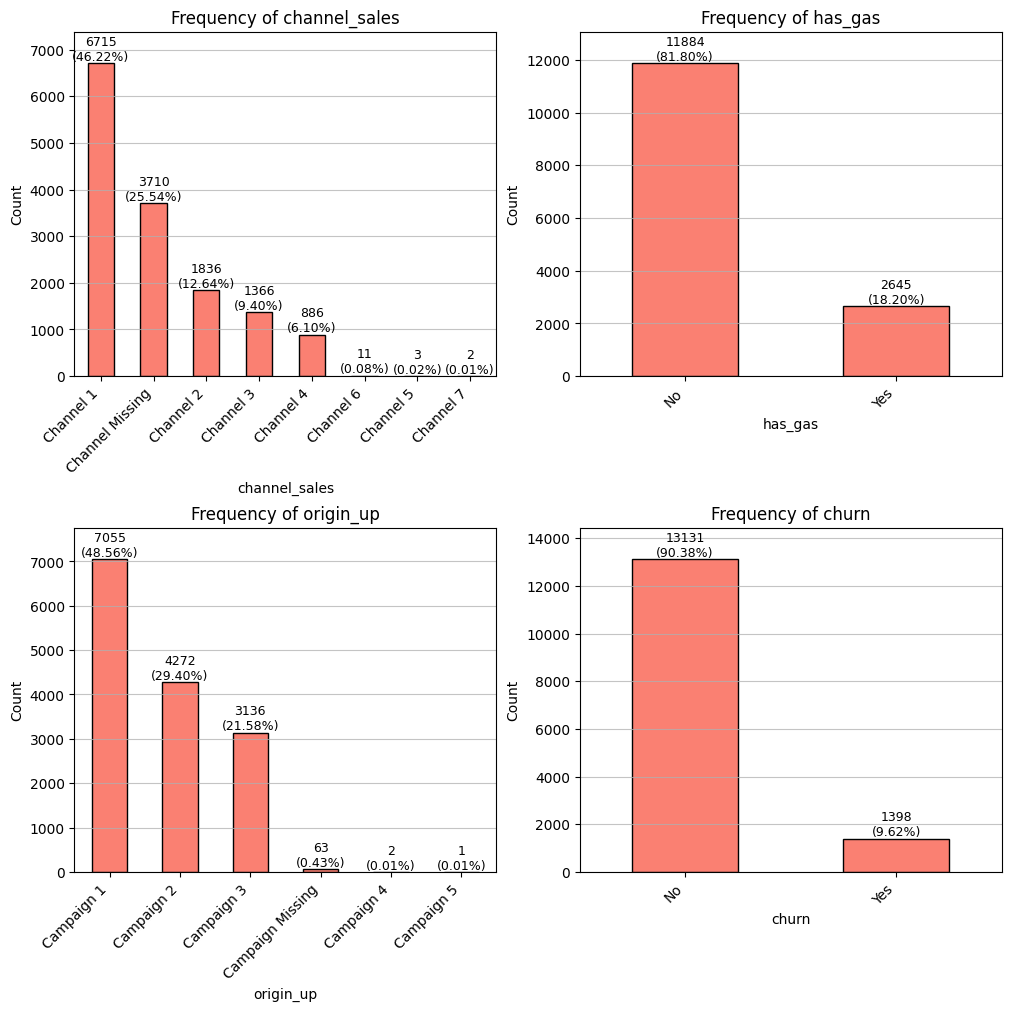

In [31]:
plot_bar_charts(merged_df, categorical_cols, sort_index=False)

As you can see, some categories are very poorly represented:

- `'Channel 5'`, `'Channel 6'` and `'Channel 7'` for the `channel_sales` variable
- `'Campaign 4'`, `'Campaign 5'` and `'Campaign Missing'` for the `origin_up` variable

Since these categories are underrepresented, they are likely to introduce noise into the data without providing enough examples to learn meaningful patterns. Therefore, it has been decided to remove the corresponding rows.

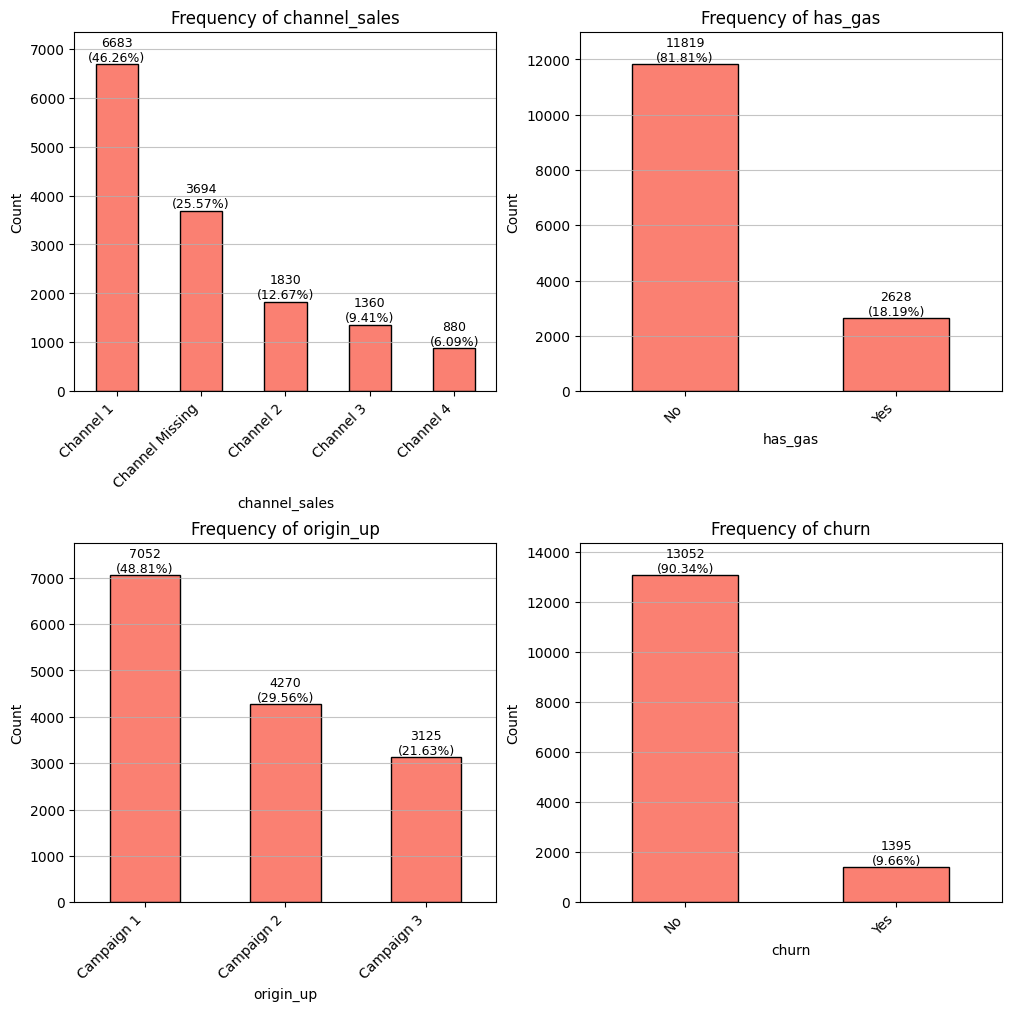

In [32]:
# Define the categories to remove for each column
channel_sales_to_remove = ['Channel 5', 'Channel 6', 'Channel 7']
origin_up_to_remove = ['Campaign 4', 'Campaign 5', 'Campaign Missing']

# Remove the rows with these values
merged_df = merged_df[~merged_df['channel_sales'].isin(channel_sales_to_remove) & ~merged_df['origin_up'].isin(origin_up_to_remove)]

plot_bar_charts(merged_df, categorical_cols, sort_index=False)

In [33]:
merged_df.to_csv(f"{repo_path}/data/merged_data.csv", index=False)